In [1]:
# Importing libraries

# Statistics
import numpy as np
import pandas as pd
import scipy


# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline


# Data preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import IterativeImputer


# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC


# Model performance
from sklearn.metrics import confusion_matrix, RocCurveDisplay, accuracy_score, f1_score, roc_auc_score


# Serializing and Deserailizing data
import pickle


# Warnings
import warnings 
warnings.filterwarnings('ignore')

# 1. Loading Data

### __Important Notes:-__
- The test data provided contains data that is already present in the train dataset. Hence, using our model to make predictions on such test data (which the model is already trained upon) will not be helpful in evaluating the model correctly as it will always give near 100% accuracy.
- So, we will randomly segregate a sample of 10,000 rows from our train data and use it as test data for our model's evaluation.

In [2]:
# Train data
df= pd.read_csv('Dataset/Train.csv')

#Data Dictionary
meta_data = pd.read_excel(open('Dataset/DATA_DICT.xlsx', 'rb'), sheet_name='Sheet2')

In [3]:
# Segregating Test data from Train Dataset
test= df.sample(n=10000, random_state=1)

# Removing the segregated test data from train data
df= df[ ~(df['cust_id'].isin(test['cust_id'])) ]

In [4]:
# Copy of the train dataset
data= df.copy()

In [5]:
# function for data dictionary
def col_desc(x):
    return meta_data[meta_data['Index']==x]['Variable']

# 2. Preliminary Data Analysis

In [6]:
df.head()

cust_id   v1      v2   v3   v4   v5   v6   v7   v8   v9  ...  v20  v21  \
0  cust_1  NaN  300000  0.0  NaN  0.0  0.0  NaN  NaN  NaN  ...    0    0   
2  cust_3  0.0  300000  1.0  1.0  1.0  0.0  0.0  0.0  0.0  ...    0   14   
3  cust_4  0.0  330000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    2    5   
5  cust_6  NaN  650000  0.0  NaN  0.0  0.0  NaN  NaN  NaN  ...    2    0   
7  cust_8  0.0  242454  1.0  1.0  1.0  0.0  0.0  0.0  0.0  ...    1   12   

    v22  v23   v24    v25  v26  v27  v28  v29  
0   7.0    0  17.0  18.99    0  NaN    0    1  
2   5.0   14  22.0  22.00    1  NaN    1    0  
3  18.0    5  24.0  22.95    1  NaN    1    1  
5   5.0    0  28.0  19.00    0  NaN    0    1  
7  19.0   12   9.0  26.17    2  NaN    2    1  

[5 rows x 30 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87918 entries, 0 to 97917
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  87918 non-null  object 
 1   v1       49361 non-null  float64
 2   v2       87918 non-null  int64  
 3   v3       87918 non-null  float64
 4   v4       49361 non-null  float64
 5   v5       87918 non-null  float64
 6   v6       87918 non-null  float64
 7   v7       49361 non-null  float64
 8   v8       49361 non-null  float64
 9   v9       49361 non-null  float64
 10  v10      49361 non-null  float64
 11  v11      49361 non-null  float64
 12  v12      49361 non-null  float64
 13  v13      49361 non-null  float64
 14  v14      87918 non-null  int64  
 15  v15      87918 non-null  object 
 16  v16      49361 non-null  float64
 17  v17      49361 non-null  float64
 18  v18      49361 non-null  float64
 19  v19      49361 non-null  float64
 20  v20      87918 non-null  int64  
 21  v21      879

__Observation:__
- Two columns namely, `cust_id` and `v15` are of 'object datatype'. Let's explore these columns first.

In [8]:
# cust_id column & v15
df[['cust_id', 'v15']]

cust_id  v15
0          cust_1   NO
2          cust_3   NO
3          cust_4  YES
5          cust_6   NO
7          cust_8   NO
...           ...  ...
97913  cust_97914   NO
97914  cust_97915   NO
97915  cust_97916  YES
97916  cust_97917   NO
97917  cust_97918   NO

[87918 rows x 2 columns]

In [9]:
# calling col_desc function to see what v15 represents
col_desc('v15')

14    NEVER_BOUNCE_FLAG
Name: Variable, dtype: object

__Observation:__
- Since `cust_id` is nothing but unique id for the customers we will drop the column.
- `v15` is a "Never Bounce Flag" so we will encode it with 1's and 0's.

In [10]:
#Drop cust_id
df.drop('cust_id', axis=1, inplace=True)

#V15 conversion
df['v15']= df['v15'].apply(lambda x: 1 if x=='YES' else 0)

### Checking  for balance in dataset

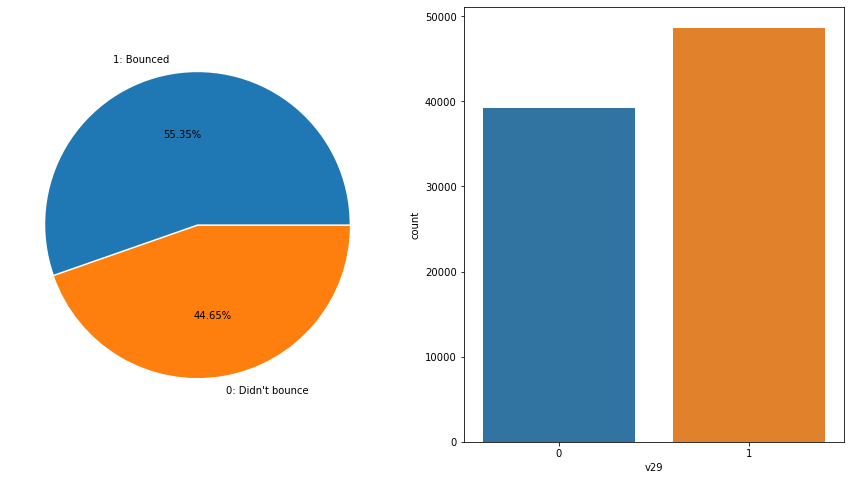

In [11]:
# Target: Bounce Flag
fig, axes= plt.subplots(1,2, figsize=(15,8))

axes[0].pie(df['v29'].value_counts(), autopct='%.2f%%', explode=[0.0,0.01], labels= ['1: Bounced',"0: Didn't bounce"])
sns.countplot(df['v29'], ax=axes[1])
plt.show()

__Observation:__
- It can be observed that the dataset is quite balanced.

### Box PLots

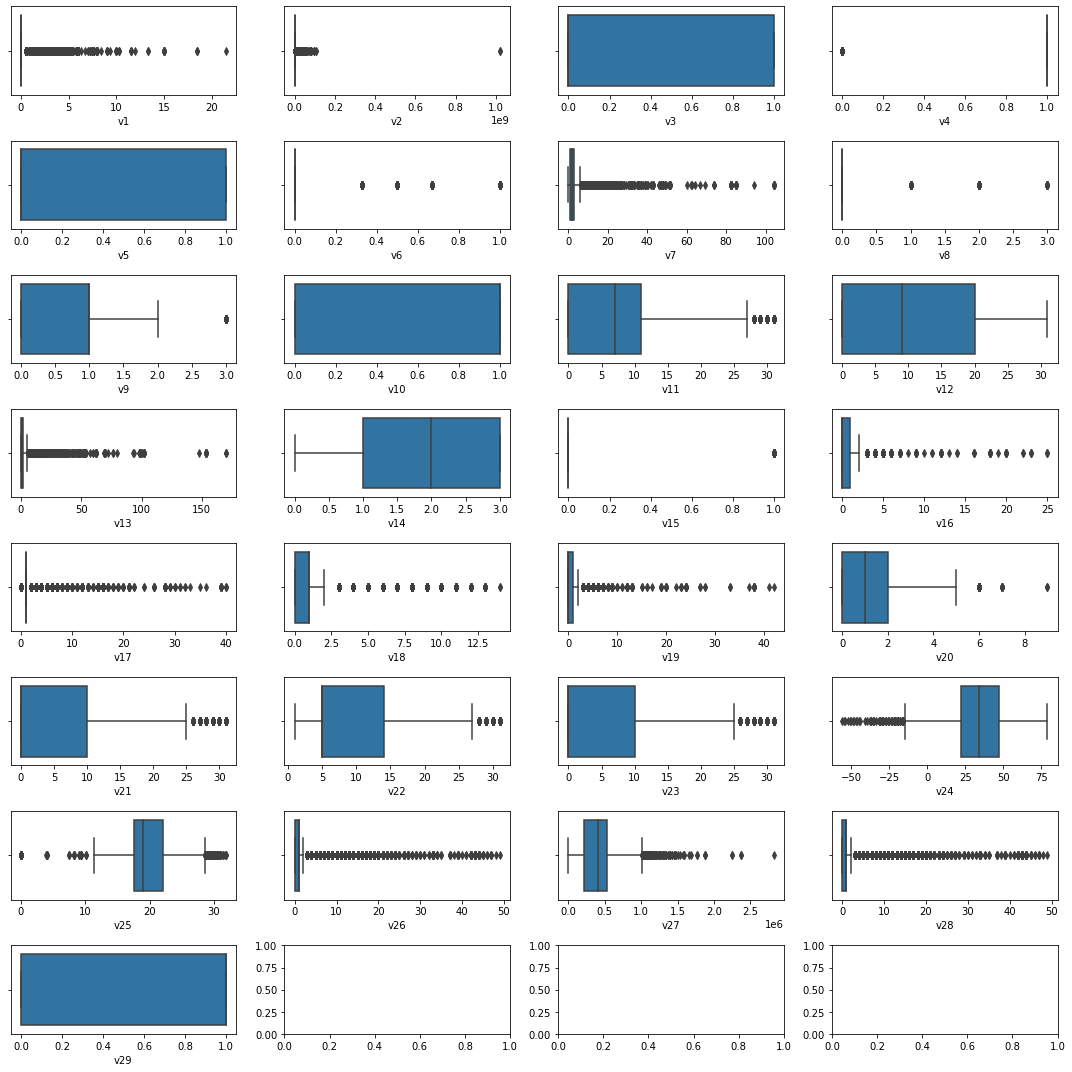

In [12]:
fig, axes= plt.subplots(nrows=8, ncols=4, figsize=(15,15))
axes=axes.flatten()

index=0

for col in df.columns:
        sns.boxplot(x=col, data=df, ax= axes[index])
        #axes[index].set_xlabel( col+": "+meta[meta['Index']==col]['Variable'].iloc[0] )
        index+=1

plt.tight_layout()
plt.show()

__Observation:__
- Outliers can be observed in `v2`, `v7`, `v13`, `v16`, `v17`, `v19`.

### Heatmap for checking correlation

<AxesSubplot:>

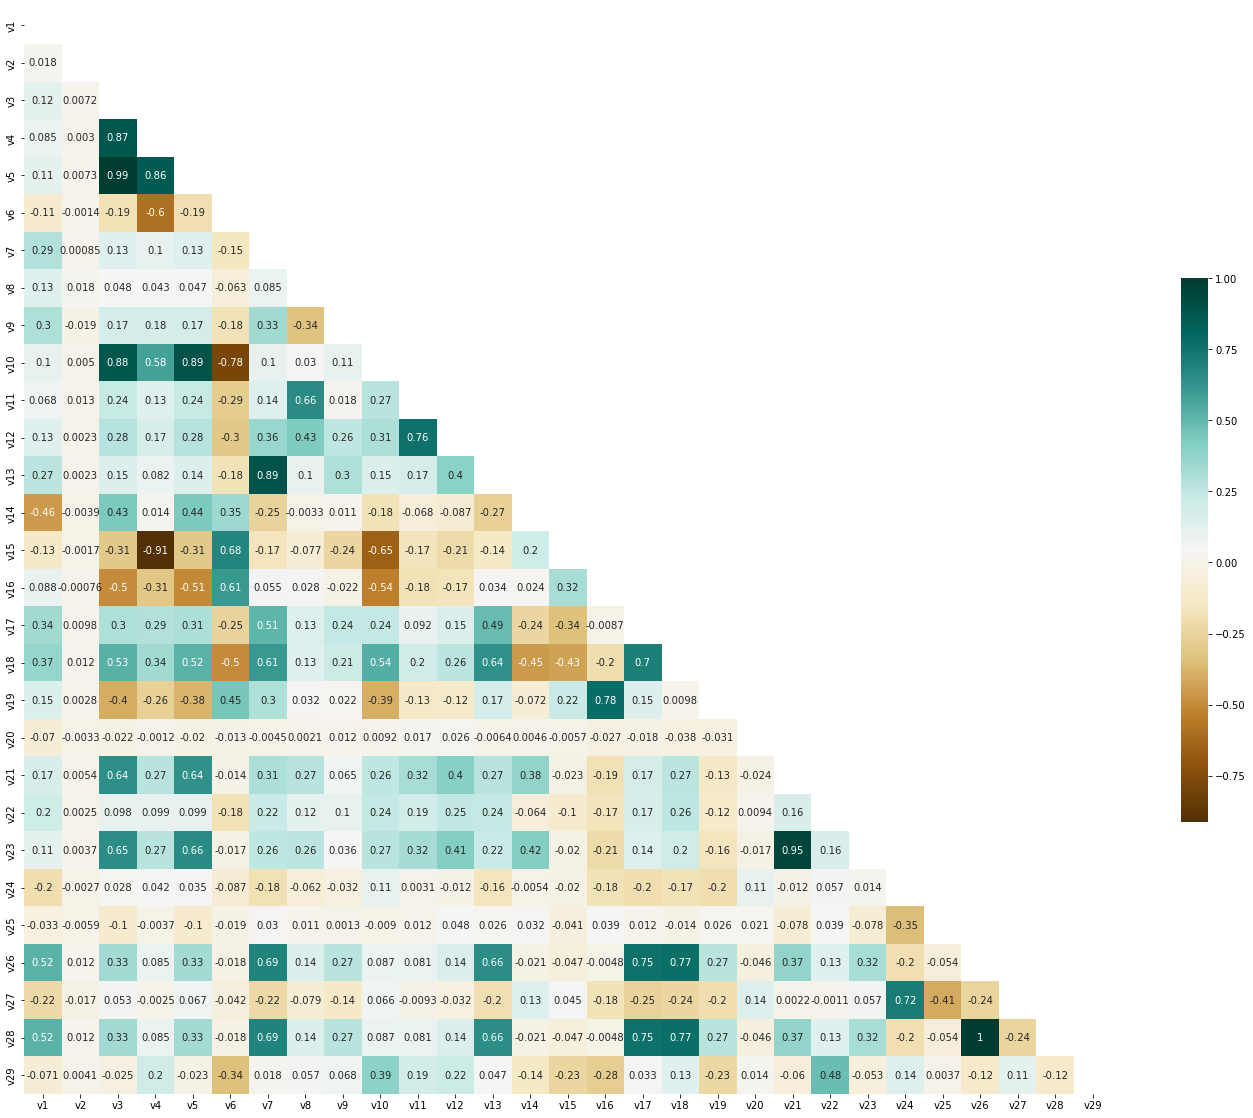

In [13]:
# Pearson’s correlation
plt.figure(figsize=(25,20))

mask = np.triu(np.ones_like(df.corr(), dtype=bool))


sns.heatmap(df.corr(), mask=mask, cmap='BrBG',annot=True,
            square=True, cbar_kws={"shrink": .5})

<AxesSubplot:>

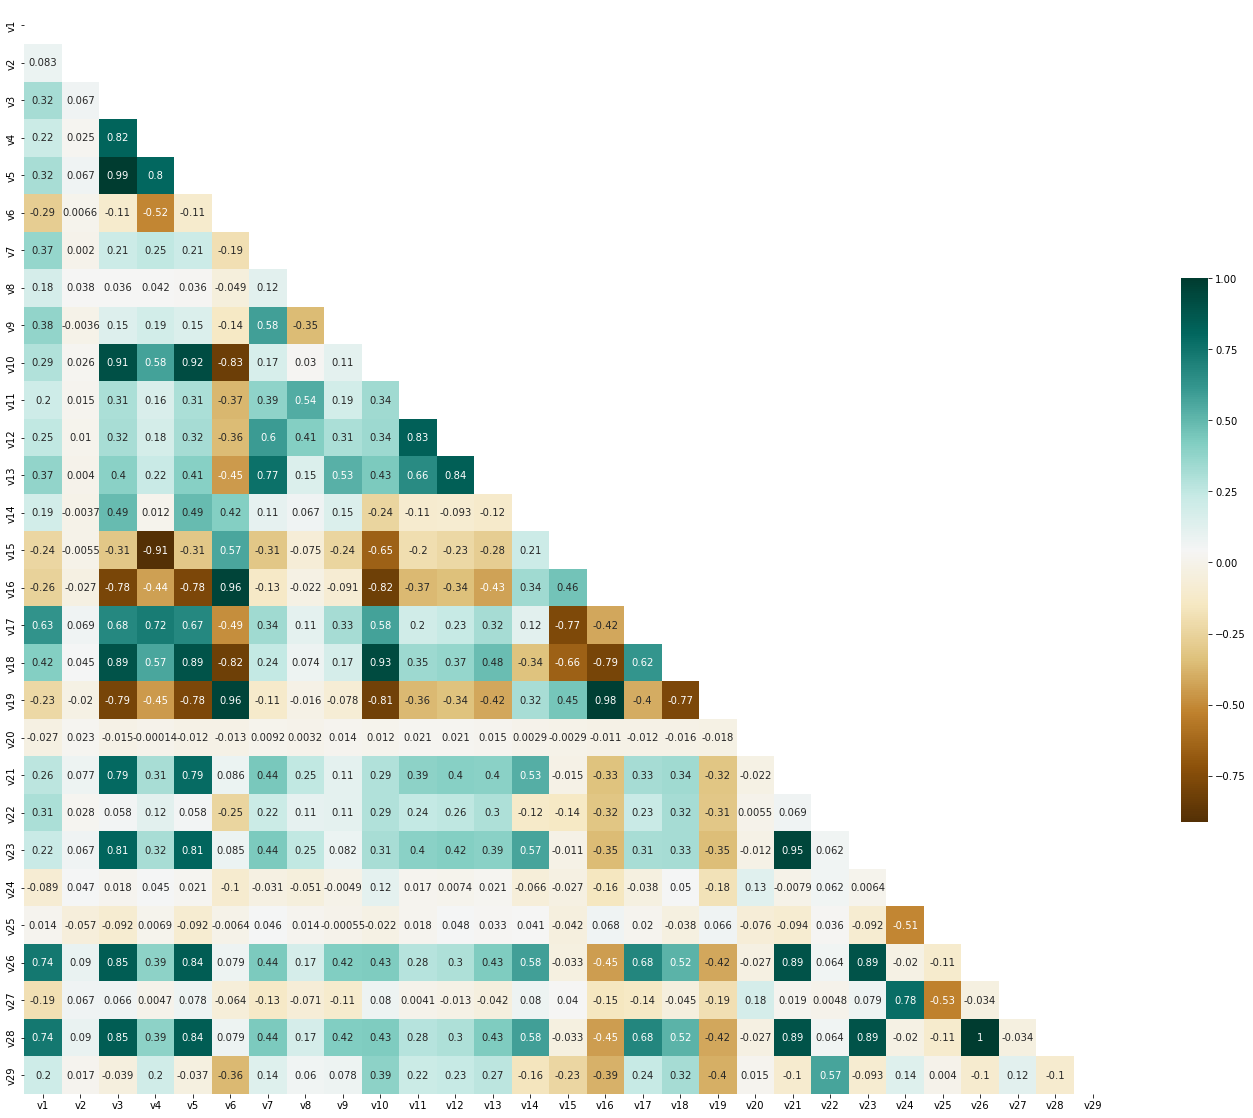

In [14]:
#Spearman rank correlation
plt.figure(figsize=(25,20))

mask = np.triu(np.ones_like(df.corr(method='spearman'), dtype=bool))


sns.heatmap(df.corr(method='spearman'), mask=mask, cmap='BrBG',annot=True,
            square=True, cbar_kws={"shrink": .5})

__Observation:__
- It can be observed that the target `v29` is most correlated with `v22` follwed by `v10` and `v18`.
- High correlations can be seen in (`v26`,`v28`), (`v3`,`v5`) and (`v16`,`v19`).

# 3. Feature Analysis and outlier handling

### 3.1. Helper Functions: First let's build some functions which would help in our analysis.

In [15]:
# General statistics

def stats(x):
    print(f"Variable: {x}")
    print(f"Type of variable: {df[x].dtype}")
    print(f"Total observations: {df[x].shape[0]}")
    detect_null_val = df[x].isnull().values.any()
    if detect_null_val:
        print(f"Missing values: {df[x].isnull().sum()} ({(df[x].isnull().sum() / df[x].isnull().shape[0] *100).round(2)}%)")
    else:
        print(f"Missing values: {df[x].isnull().values.any()}")
    print(f"Unique values: {df[x].nunique()}")
    if df[x].dtype != "O":
        print(f"Min: {int(df[x].min())}")
        print(f"25%: {int(df[x].quantile(q=[.25]).iloc[-1])}")
        print(f"Median: {int(df[x].median())}")
        print(f"75%: {int(df[x].quantile(q=[.75]).iloc[-1])}")
        print(f"Max: {int(df[x].max())}")
        print(f"Mean: {df[x].mean()}")
        print(f"Mode: {df[x].mode()[0]}")
        print(f"Std dev: {df[x].std()}")
        print(f"Variance: {df[x].var()}")
        print(f"Skewness: {scipy.stats.skew(df[x])}")
        print(f"Kurtosis: {scipy.stats.kurtosis(df[x])}")
        print("")
        
    # Percentiles 1%, 5%, 95% and 99%
        print("Percentiles 1%, 5%, 95%, 99%")
        display(df[x].quantile(q=[.01, .05, .95, .99]))
        print("")
    else:
        print(f"List of unique values: {df[x].unique()}")  

In [16]:
# Boxplots and Histgrams
def box_hist(feat):
    fig, axes= plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 5]})

    sns.boxplot(x=feat, data=df, ax=axes[0])
    sns.histplot(x=feat, data=df, ax=axes[1])
    plt.suptitle(feat+": "+meta_data[meta_data['Index']==feat]['Variable'].iloc[0])

### 3.2. Feature v2: salary of customer

In [17]:
stats('v2')

Variable: v2
Type of variable: int64
Total observations: 87918
Missing values: False
Unique values: 12787
Min: 0
25%: 185280
Median: 275000
75%: 403800
Max: 1020000000
Mean: 431884.4555039923
Mode: 275000
Std dev: 5183346.255993203
Variance: 26867078409518.76
Skewness: 174.42705991848896
Kurtosis: 34069.68986838069

Percentiles 1%, 5%, 95%, 99%


0.01      18800.85
0.05      38672.20
0.95     825000.00
0.99    1625000.00
Name: v2, dtype: float64

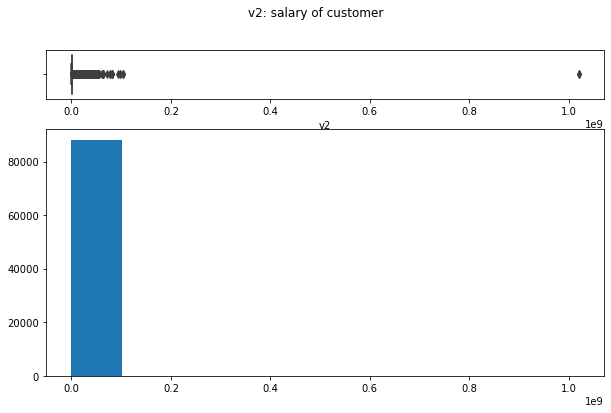

In [18]:
#box_hist('v2')
fig, axes= plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 5]})

sns.boxplot(x='v2', data=df, ax=axes[0])
axes[1].hist(df['v2'])

plt.suptitle('v2'+": "+meta_data[meta_data['Index']=='v2']['Variable'].iloc[0])
plt.show()

__Observation:__
- We can see that there are a lot of outliers so let's handle them using binning.

In [19]:
# binning the salary column

def salary_cat(x):
    if(x<250000): return 1
    elif (250000<=x<500000): return 2
    elif (500000<=x<1000000): return 3
    elif (1000000<=x<2500000): return 4
    elif (2500000<=x<5000000): return 5
    elif (5000000<=x<10000000): return 6
    else: return 7 
    

df['v2']= df['v2'].apply(lambda x: salary_cat(x))


### 3.3. Feature v7: LATEST_3 MONTHONTH_AVARAGE UNIQ_INTENSITY

In [20]:
stats('v7')

Variable: v7
Type of variable: float64
Total observations: 87918
Missing values: 38557 (43.86%)
Unique values: 144
Min: 0
25%: 1
Median: 2
75%: 3
Max: 104
Mean: 2.5532787018091216
Mode: 2.0
Std dev: 4.312973189163707
Variance: 18.601737730444963
Skewness: nan
Kurtosis: nan

Percentiles 1%, 5%, 95%, 99%


0.01     0.0
0.05     0.0
0.95     8.0
0.99    16.5
Name: v7, dtype: float64

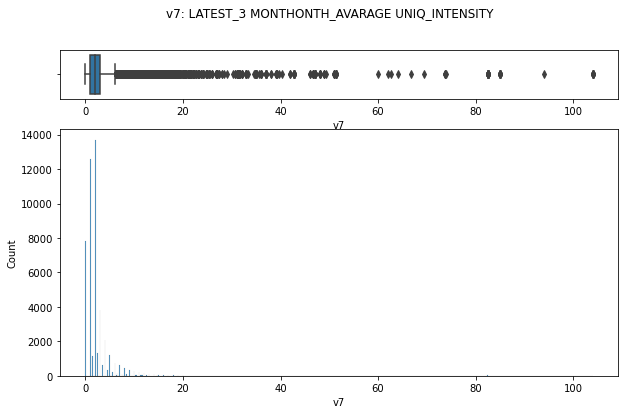

In [21]:
box_hist('v7')

In [22]:
#Removing Outliers
df= df[~(df['v7']>9)]

### 3.4. Feature: v24: remaining tenure of customer

In [23]:
stats('v24')

Variable: v24
Type of variable: float64
Total observations: 86107
Missing values: 172 (0.2%)
Unique values: 116
Min: -38
25%: 22
Median: 34
75%: 47
Max: 79
Mean: 34.83062780008146
Mode: 23.0
Std dev: 14.7532508213826
Variance: 217.65840979862637
Skewness: nan
Kurtosis: nan

Percentiles 1%, 5%, 95%, 99%


0.01     9.0
0.05    12.0
0.95    58.0
0.99    59.0
Name: v24, dtype: float64

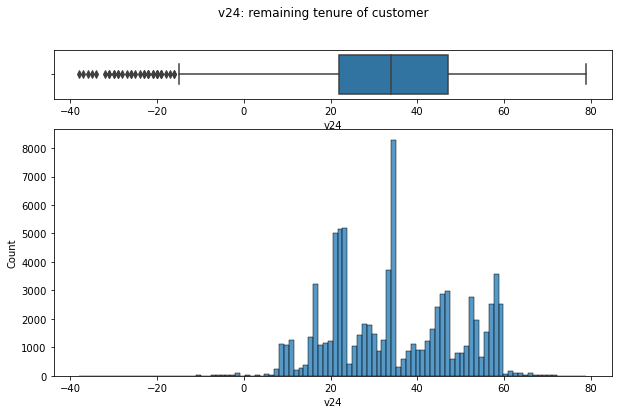

In [24]:
box_hist('v24')

__Observation:__
- There are negative values in this feature but remaining tenure can't be negative and there are approximately only 800 observations with negative values, which is not much, so it will be safe to remove them.

In [25]:
# removing negative values as tenure can't be negative and it can't contribute to the target
df= df[~(df['v24']<0)]

### 3.5. Feature: v25: RATE OF INTEREST

In [26]:
stats('v25')

Variable: v25
Type of variable: float64
Total observations: 85812
Missing values: False
Unique values: 1623
Min: 0
25%: 17
Median: 19
75%: 22
Max: 31
Mean: 19.569613224261477
Mode: 19.0
Std dev: 3.876840091690328
Variance: 15.029889096537469
Skewness: -0.970869704440993
Kurtosis: 6.295608087721105

Percentiles 1%, 5%, 95%, 99%


0.01     0.0000
0.05    15.1800
0.95    26.3000
0.99    28.3689
Name: v25, dtype: float64

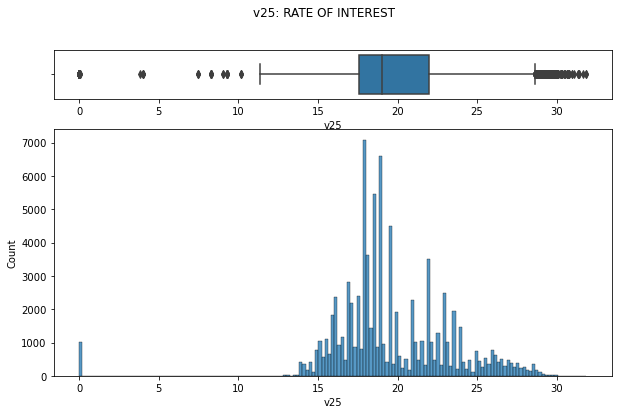

In [27]:
box_hist('v25')

__Observation:__
- Rate of interest can't be zero and average tractor loan rates are above 9% even in case of government banks so we should drop these observations/rows.

In [28]:
# Removing outliers using IQR(Inter Quartile Range)
Q1= df['v25'].quantile(0.25)
Q3= df['v25'].quantile(0.75)
IQR= Q3-Q1

df= df[~( df['v25']<(Q1-1.5*IQR)) ]

### 3.6. Feature: v26: total number of dre receipt cut

In [29]:
stats('v26')

Variable: v26
Type of variable: int64
Total observations: 84766
Missing values: False
Unique values: 20
Min: 0
25%: 0
Median: 0
75%: 1
Max: 19
Mean: 0.6504140811174292
Mode: 0
Std dev: 0.9354669711685824
Variance: 0.8750984541473213
Skewness: 5.2680619730642055
Kurtosis: 61.88835858512965

Percentiles 1%, 5%, 95%, 99%


0.01    0.0
0.05    0.0
0.95    2.0
0.99    2.0
Name: v26, dtype: float64

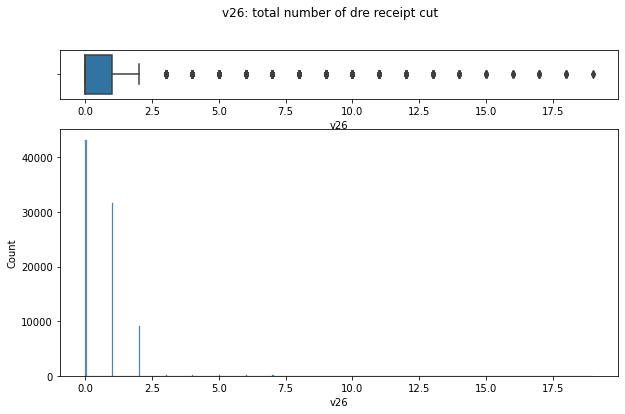

In [30]:
box_hist('v26')

In [31]:
pd.crosstab(df['v29'], df['v26'])

v26     0      1     2    3    4   5   6   7   8   9   10  11  12  13  14  15  \
v29                                                                             
0    16039  18646  2057  159  125  96  80  57  50  42  39  24  22  16  12   7   
1    27056  13006  7145   66    1   0   0   0   0   0   0   0   0   0   0   0   

v26  16  17  18  19  
v29                  
0     5   8   6   2  
1     0   0   0   0

__Observation:__
- Since all observations with receipt cuts more than 4 have not bounced and only 1 observation with recipt cut 4 has bounced we can handle the outliers by imputing all observations, having receipt cut greater than 3, with 5.

In [32]:
# Imputing v26 by 5 wherever it's greater than 4
df['v26']=df['v26'].apply(lambda x: x if x<4 else 5 )

# 4. Removing some features

- We will drop `v28`, `v5` and `v13` as
 - these are extremely collinear with some other features and this could lead to overfitting.
 - dropping these would reduce dimensionality. 

In [33]:
df.drop(['v28', 'v5','v13'], axis=1, inplace=True)

# 5. Handling missing data

In [34]:
null_feat= pd.DataFrame(df.isna().sum().sort_values(ascending=False), columns=['Absolute'])
null_feat['Percentage']= (null_feat['Absolute']/len(df))*100
null_feat.head(16)

Absolute  Percentage
v27     66942   78.972701
v1      38165   45.023948
v10     38165   45.023948
v19     38165   45.023948
v18     38165   45.023948
v17     38165   45.023948
v12     38165   45.023948
v11     38165   45.023948
v16     38165   45.023948
v9      38165   45.023948
v7      38165   45.023948
v4      38165   45.023948
v8      38165   45.023948
v22      9761   11.515230
v24       170    0.200552
v3          0    0.000000

__Observation:__
- Since `v27` has 78% missing data it's not worth imputing it and we will drop the feature.
- `v24` has very less missing data so we will remove those rows.
- We will impute rest of the missing data using scikit-learn's 'IterativeImputer'.

In [35]:
df.drop('v27', axis=1, inplace=True)
df.dropna(axis=0, subset='v24', inplace=True)

# 6. Imputing Missing values

In [36]:
# Imputing using IterativeImputer

imputer= IterativeImputer()
df.iloc[:,:-1]= imputer.fit_transform(df.drop('v29',axis=1))

# Saving the imputer
pickle.dump(imputer, open('Models/Imputer', 'wb'))

# 7. Test Data Preprocessing

In [37]:
def test_preprocessing(data):
    
    # Dropping some features 'v5', 'v13', 'v27', 'v28'
    data.drop(['cust_id', 'v5', 'v13', 'v27', 'v28' ], axis=1, inplace=True )

    #Encoding feature v15
    data['v15']= data['v15'].apply(lambda x: 1 if x=='YES' else 0)

    # Function for binning the salary feature
    def salary_cat(x):
        if(x<250000): return 1
        elif (250000<=x<500000): return 2
        elif (500000<=x<1000000): return 3
        elif (1000000<=x<2500000): return 4
        elif (2500000<=x<5000000): return 5
        elif (5000000<=x<10000000): return 6
        else: return 7 
    
    # Binning the salary feature
    data['v2']= data['v2'].apply(lambda x: salary_cat(x))
    
    #Loading imputer model
    imputer = pickle.load(open('Models/Imputer', 'rb'))
    
    # Imputing missing values in test data
    data.iloc[:,:-1]= imputer.transform(data.drop('v29',axis=1))

In [38]:
# Calling pre-processing function on test data
test_preprocessing(test)

# 8. Model Training, Testing & Evaluation

Here, we will evaluate the performance of various ML models before choosing the best one. To maximise their performance, we shall then carry out hyperparameter optimization on the best performing models.

In [39]:
# Splitting data for model

X_train= df.drop('v29', axis=1).copy()
y_train= df['v29'].copy()

X_test= test.drop('v29', axis=1).copy()
y_test= test['v29'].copy()

In [40]:
# Scaling
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

#Saving the scaler
pickle.dump(scaler, open('Models/Scaler', 'wb'))

### 8.1. Model Training

In [41]:
# XGBoost Classifier
xgb= XGBClassifier()

xgb.fit(X_train, y_train)
xgb_pred= xgb.predict(X_test)

In [42]:
# Logistic Regression
LR= LogisticRegression()

LR.fit(X_train, y_train)
LR_pred= LR.predict(X_test)

In [43]:
# Random Forest Classifier
rfc= RandomForestClassifier()

rfc.fit(X_train, y_train)
rfc_pred= rfc.predict(X_test)

In [44]:
# Support Vector Classifier
svc= SVC()
svc.fit(X_train,y_train)
svc_pred= svc.predict(X_test)

In [45]:
# LightGBM Classifier
Lgbm= LGBMClassifier()
Lgbm.fit(X_train,y_train)
Lgbm_pred= Lgbm.predict(X_test)

In [46]:
# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

#Using early stop to halt training at the right time
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

#model structure
ann_model = Sequential()

ann_model.add(Dense(units=48, activation='relu'))
ann_model.add(Dense(units=24, activation='relu'))
ann_model.add(Dense(units=12, activation='relu'))
ann_model.add(Dense(units=6, activation='relu'))

ann_model.add(Dense(units=1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy')

# Model fitting & predictions
ann_model.fit(X_train, y_train,
          epochs=1000,
          validation_data=(X_test,y_test),
          verbose=1,
          callbacks= [early_stop]
 )

ann_prob= ann_model.predict(X_test)
ann_pred= np.where(ann_prob>0.5, 1, 0)

Epoch 1/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3914 - val_loss: 0.3650
Epoch 2/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3319 - val_loss: 0.3416
Epoch 3/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3187 - val_loss: 0.3330
Epoch 4/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3125 - val_loss: 0.3251
Epoch 5/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3094 - val_loss: 0.3271
Epoch 6/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3068 - val_loss: 0.3202
Epoch 7/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3052 - val_loss: 0.3151
Epoch 8/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3047 - val_loss: 0.3210
Epoch 9/1000
2644/2644 [==============================] - 5s 2ms/step - loss: 0.3036 - val_loss: 0.3162
Epoch 10/1000
2644/2644 [==============================] - 4s 2m

### 8.2. Model performance evaluation

In [47]:
# Model Performance Matrix

#function to calculate metrics
def perf_matrix(y_pred, model):
    tn, fp, fn, tp = (confusion_matrix(y_test, y_pred).ravel()/len(y_test))*100
    acc= accuracy_score(y_test,y_pred)
    f1score= f1_score(y_test, y_pred)
    return pd.DataFrame({
                        'Model':[model], 
                        'Accuracy' :[acc],
                        'TP%':[tp], 
                        'FP%':[fp], 
                        'FN%':[fn], 
                        'TN%':[tn],
                        'F1_score' :[f1score]
                        })

#list of models
model_list= [(LR_pred, 'LogisticRegression'), (rfc_pred, 'RandomForestClassifier'), (xgb_pred, 'XGBClassifier'),
             (Lgbm_pred, 'LGBMClassifier'), (svc_pred, 'SVC-Classifier'), (ann_pred, 'Neural Network') ]

#performance matrix
performance= pd.DataFrame(columns=['Model', 'Accuracy', 'TP%', 'FP%', 'FN%', 'TN%', 'F1_score' ])

for y_pred, model in model_list:
    performance= pd.concat([performance, perf_matrix(y_pred, model) ], axis=0)
    
    
performance.sort_values( 'Accuracy', ascending=False, inplace=True)
performance.reset_index(drop=True, inplace=True)    

In [48]:
performance

Model Accuracy    TP%    FP%    FN%    TN%  F1_score
0          LGBMClassifier   0.8855  51.17   6.99   4.46  37.38  0.899376
1           XGBClassifier   0.8826  51.02   7.13   4.61  37.24  0.896818
2          Neural Network   0.8779  50.83   7.41    4.8  36.96  0.892772
3  RandomForestClassifier   0.8697  50.16   7.56   5.47  36.81  0.885046
4          SVC-Classifier   0.8396  50.74  11.15   4.89  33.22  0.863513
5      LogisticRegression   0.7846  44.67  10.58  10.96  33.79  0.805736

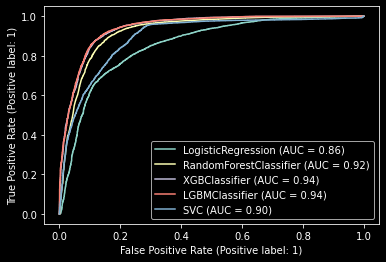

In [49]:
plt.style.use('dark_background')

# Roc curve
ax = plt.gca()

model_list =[LR, rfc, xgb, Lgbm, svc]

for model in model_list:
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)

plt.show()

__Observation:__
- The LightGBM classifier and XGBoost classifier are performing the best, with accuracy scores of 88.55 and 88.26 respectively. Hence, we will proceed with tuning their hyperparameters.

# 9. Hyperparameter Optimization

#### Model 1: LightGBM Classifier

In [50]:
# #Hyperparameter Tuning

# from datetime import datetime
# start = datetime.now()     #Noting start time

# #Defining the parameters
# params ={
#     'boosting_type'      : ['dart'],
#     'num_leaves'         : [5, 10, 15, 20, 25],
#     'max_depth'          : [1, 2, 3, 5, 7, None],
#     'learning_rate'      : [0.005, 0.04, 0.05,0.1],
#     'n_estimators'       : [300, 400, 500, 600, 700],
#     'min_child_samples'  : [300,350,400,450,500], 
#     'min_child_weight'   : [0.01, 0.1, 1, 10]}

# #Running RandomizedSearchCV
# Lgbm= LGBMClassifier()
# random_search= RandomizedSearchCV(Lgbm, param_distributions=params, 
#                                   n_iter=10,
#                                   scoring='accuracy',
#                                   n_jobs=-1,
#                                   cv= 3,
#                                   verbose=1)

# random_search.fit(X_train,y_train)


# end = datetime.now()     #Noting end time
# td = (end - start).total_seconds()/60
# print(f"The time of execution of above program is : {td:.03f}mins")

# print(f"The best estimator's parameters are:\n{random_search.best_estimator_}\n")
# print(f"The best estimator's score is:{random_search.best_score_}")

__Observation:__

We will modify some of these parameters (to prevent overfitting and improve accuracy) and then pass them to our model.

In [51]:
# LightGBM Classifier fit & predict 88.68

Lgbm= LGBMClassifier(boosting_type='dart', learning_rate=0.04, max_depth=5,
                     min_child_samples=300, min_child_weight=0.1, n_estimators=650,
                     num_leaves=14)


Lgbm.fit(X_train, y_train)
Lgbm_pred= Lgbm.predict(X_test)

#Saving the model
pickle.dump(Lgbm, open('Models/LGBMClassifier', 'wb'))

#### Model 2: XGBoost Classifier

In [52]:
# #Hyperparameter Tuning

# from datetime import datetime
# start = datetime.now()     #Noting start time

# #Defining the parameters
# params= {
#     'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
#     'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
#     'max_depth': [5,6,7,8,9,10,11,12,13,14, None],
#     'n_estimators': [50, 65, 80, 100, 115, 130, 150, 300, 400, 500, 600, 700],
#     'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#     'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

# #Running RandomizedSearchCV
# xgb= XGBClassifier()
# random_search= RandomizedSearchCV(xgb, param_distributions=params, 
#                                   n_iter=300, 
#                                   scoring='accuracy',
#                                   n_jobs=-1,
#                                   cv= 3,
#                                   verbose=1)

# random_search.fit(X_train,y_train)


# end = datetime.now()     #Noting end time
# td = (end - start).total_seconds()/60
# print(f"The time of execution of above program is : {td:.03f}mins")

# print(f"The best estimator's parameters are:\n{random_search.best_params_}\n")
# print(f"The best estimator's score is:{random_search.best_score_}")

In [53]:
# XGBoost Classifier fit & predict
xgb= XGBClassifier(reg_lambda= 51.2, reg_alpha= 0.4, n_estimators= 65,
                   max_depth= 7, learning_rate= 0.5,  gamma= 25.6)


xgb.fit(X_train, y_train)
xgb_pred= xgb.predict(X_test)

Now, let us see which model performed better after hyperparamter optimization.

#### Model Performance

In [54]:
#list of models
model_list= [(LR_pred, 'LogisticRegression'), (rfc_pred, 'RandomForestClassifier'), (xgb_pred, 'XGBClassifier'),
             (Lgbm_pred, 'LGBMClassifier'), (svc_pred, 'SVC-Classifier'), (ann_pred, 'Neural Network') ]

#performance matrix
performance= pd.DataFrame(columns=['Model', 'Accuracy', 'TP%', 'FP%', 'FN%', 'TN%', 'F1_score' ])

for y_pred, model in model_list:
    performance= pd.concat([performance, perf_matrix(y_pred, model) ], axis=0)
    
    
performance.sort_values( 'Accuracy', ascending=False, inplace=True)
performance.reset_index(drop=True, inplace=True) 

performance

Model Accuracy    TP%    FP%    FN%    TN%  F1_score
0          LGBMClassifier   0.8868  51.29   6.98   4.34  37.39  0.900615
1           XGBClassifier   0.8848  51.24   7.13   4.39  37.24  0.898947
2          Neural Network   0.8779  50.83   7.41    4.8  36.96  0.892772
3  RandomForestClassifier   0.8697  50.16   7.56   5.47  36.81  0.885046
4          SVC-Classifier   0.8396  50.74  11.15   4.89  33.22  0.863513
5      LogisticRegression   0.7846  44.67  10.58  10.96  33.79  0.805736

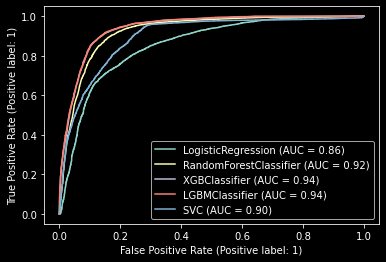

In [55]:
# Roc Curve
ax = plt.gca()

model_list =[LR, rfc, xgb, Lgbm, svc]

for model in model_list:
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)

plt.show()

__Observation:__

Both XGBoost and LightGBM have similar performance, but since LightGBM has slightly higher accuracy and is almost 6 times faster than XGBoost, we should use LightGBM for further predictions.

# 10. Explaining Model Output using SHAP (SHapley Additive exPlanations)

In [56]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [57]:
# get feature names
feat_names= list(df.drop('v29', axis=1).columns)


# Loading the model
model = pickle.load(open('Models/LGBMClassifier', 'rb'))

# explain the model's predictions using SHAP
explainer = shap.explainers.Tree(model, X_train, feature_names= feat_names)
shap_values = explainer(X_train)

100%|===================| 84572/84596 [15:58<00:00]        

In [58]:
# Changing standard-scaled data to original form
shap_values.data= df.drop('v29', axis=1).values

### 10.1. Global feature importance plot

This plot tells us which features are more important for the model along with a value assigned to every feature. The assigned values are the maean absolute SHAP values, calculated as: mean(|SHAP value|), of every feature. The greater the mean absolute SHAP value the more important the feature is to the model.

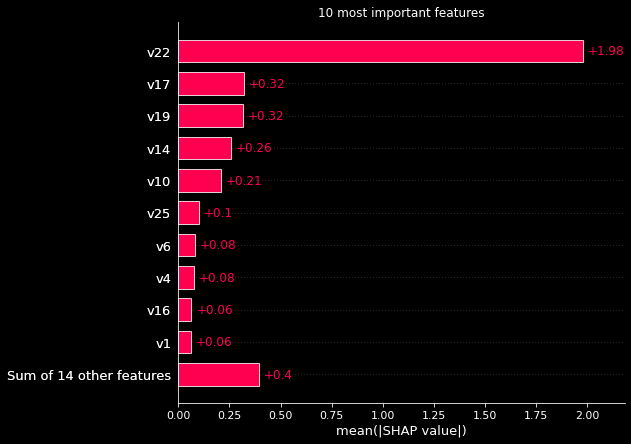

In [59]:
plt.title('10 most important features')
shap.plots.bar(shap_values, max_display=11)

__Observation:__
- `v22` is the most important feature followed by `v17` and `v19` .

### 10.2. Impact of features on model
This plot shows the impacts of various features on our model and also tells us what the impact is i.e., positive or negative.

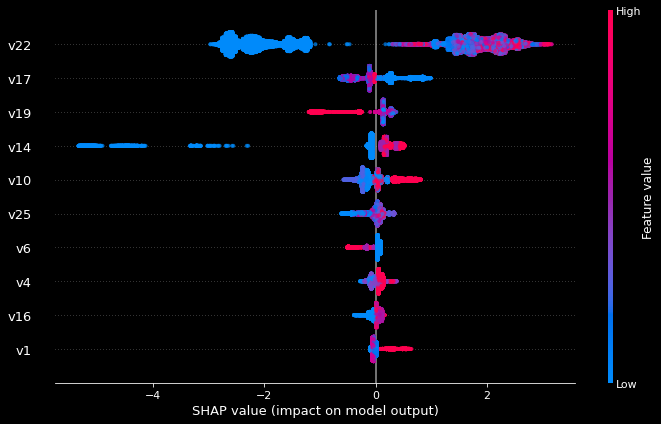

In [60]:
shap.summary_plot(shap_values, max_display=10, axis_color='#FFFFFF', alpha=0.7, plot_size=(10,6))

### 10.3. Impact of features on single observations

In [61]:
#Lambda function to convert 1&0 to bounce and not Bounce
bounce_func= lambda x: 'Bounced' if x==1 else 'Not Bounced'

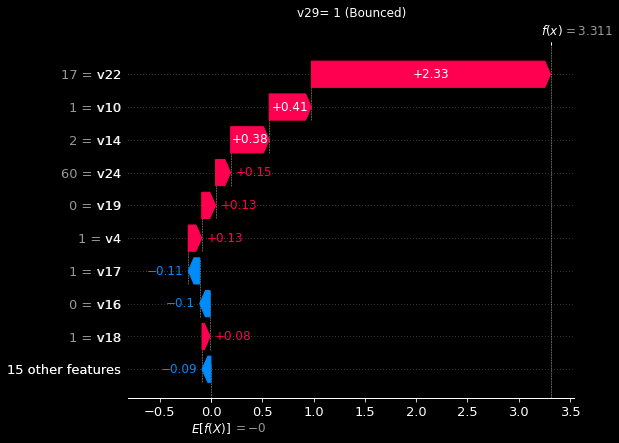

In [71]:
#selecting a random index
index= np.random.randint(0,len(X_train))

#target value
target= df.iloc[index]['v29'].copy()

#display plot
plt.title(f"v29= {int(target)} ({bounce_func(target)})")
shap.plots.waterfall(shap_values[index], show=True)

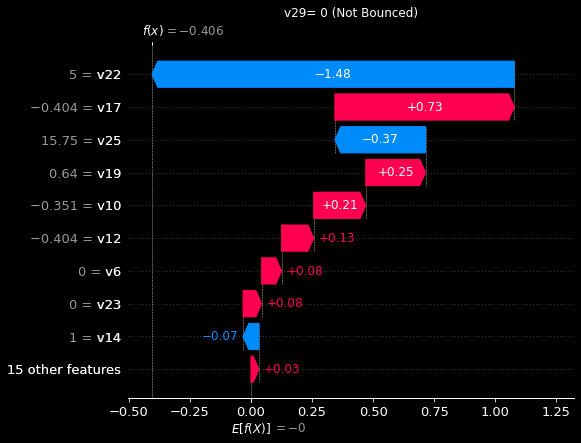

In [63]:
#selecting a random index
index= np.random.randint(0,len(X_train))

#target value
target= df.iloc[index]['v29'].copy()

#display plot
plt.title(f"v29= {int(target)} ({bounce_func(target)})")
shap.plots.waterfall(shap_values[index], show=True)

### 10.4. Analysis of v22: On which day receipt cut has been done

In [64]:
# Number of customers bounced on every receipt cut day
data_c= data.groupby(['v22', 'v29']).agg(count=('v2','count')).reset_index()
data_c['v29']=data_c['v29'].apply(lambda x: 'Bounced' if x==1 else 'Not Bounced')

fig= px.bar(data_c, x='v22', y='count', barmode='group',
            color='v29', color_discrete_sequence= ['Teal', 'Orange']
    
           )

fig.update_layout(
    height=400,
    width=800,
    template='plotly_dark+ygridoff',
    coloraxis_showscale=False)

fig.update_xaxes(title= 'v22: On which day receipt cut has been done', dtick=1)
fig.update_yaxes(title= 'No. of customers')
fig

__Observation:__
- Most of the customers had their receipt cut on 5th
- Among the customers, whose receipt cut day is 5, bounce rates are incredibly low.

In [65]:
# Bounce ratio based on v22:Receipt cut day
data_c= pd.crosstab(data['v22'],data['v29']).reset_index()
data_c.columns.rename(None, inplace=True)
data_c['bounceRatio']= round(data_c[1]/data_c[0],2)

fig= px.bar(data_c, x='v22', y='bounceRatio', text_auto=True,
            color='bounceRatio',
            color_continuous_scale= 'bluyl'
           )

fig.update_layout(
    height=400,
    width=800,
    template='plotly_dark',
    coloraxis_showscale=False)

fig.update_traces(textposition='outside')
fig.update_xaxes(title= 'v22: On which day receipt cut has been done', dtick=1)
fig.update_yaxes(title= 'Bounce Ratio')
fig

__Observation:__
- Customers whose receipt cut date is 1 are highly likely to bounce the EMI as Day 1 has the greatest bounce ratio., whilst those whose receipt cut date is 5 are extremely unlikely to do so. 